In [1]:
import numpy as np
import codecs
import argparse
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from nltk import Tree
import random
import math
import subprocess
import sys
from collections import deque, Counter, defaultdict
from scipy.sparse.csgraph import minimum_spanning_tree
import string

%matplotlib inline

In [2]:
attention_file = '../BertAA/attentions.npz'
token_file = '../BertAA/source.txt'

maxlen = 1000

fontsize=8

#this is necessary in this case
eos =True
no_softmax = True

In [3]:
def aggregate_subtoken_matrix(attention_matrix, wordpieces):
    # this functions connects subtokens and aggregates their attention.
    aggregate_wps = []
    wp_ids = []
    for wp_id, wp in enumerate(wordpieces):
        wp_ids.append(wp_id)
        if not wp.endswith('@@'):
            aggregate_wps.append(wp_ids)
            wp_ids = []

    midres_matrix = np.zeros((len(aggregate_wps), len(wordpieces)))

    for tok_id, wp_ids in enumerate(aggregate_wps):
        midres_matrix[tok_id,: ] = np.mean(attention_matrix[wp_ids, :], axis=0)

    res_matrix = np.zeros((len(aggregate_wps), len(aggregate_wps)))

    for tok_id, wp_ids in enumerate(aggregate_wps):
        res_matrix[:, tok_id] = np.sum(midres_matrix[:, wp_ids], axis=1)

    words = ' '.join(wordpieces).replace('@@ ', '')
    res_tokens = words.split()

    assert len(res_tokens) == len(aggregate_wps), "Result matrix and token dimesnions don't match"
    return res_matrix

# recursively aggregated -- attention over input tokens
def wm_aggreg(this_layer, last_layer):
    return (np.matmul(this_layer, last_layer) + last_layer) / 2

# this layer and residual connection -- attention over positions
def wm_avg(this_layer, first_layer):
    return (this_layer + first_layer) / 2

In [4]:
attentions_loaded = np.load(attention_file)
sentences_count = 1000
layers_count = attentions_loaded['arr_0'].shape[0]
heads_count = attentions_loaded['arr_0'].shape[1]


viss = dict()
word_mixtures = dict()
words_lists = dict()
with open(token_file) as tokens_file:
    tokens_loaded = [l.split() for l in tokens_file]

for sentence_index in range(sentences_count):

    sentence_id = 'arr_' + str(sentence_index)
    tokens_count = attentions_loaded[sentence_id].shape[2]
    if eos:
        tokens_count -= 1
    tokens_list = tokens_loaded[sentence_index]

    # check maxlen
    words = ' '.join(tokens_list).replace('@@ ', '')

    words_list = words.split()
    if len(words_list) <= maxlen:
        print('Processing sentence', sentence_index, file=sys.stderr)
    else:
        continue

    # NOTE sentences truncated to 64 tokens
    # assert len(tokens_list) == tokens_count, "Bad no of tokens in sent " + str(sentence_index)
    assert len(tokens_list) >= tokens_count, "Bad no of tokens in sent " + str(sentence_index)
    if len(tokens_list) > tokens_count:
        print('Too long sentence, skipped', sentence_index, file=sys.stderr)
        continue
    #     TRUNCATED = True
    #     print('Truncating tokens from ', len(tokens_list), 'to', tokens_count,
    #           'on line', sentence_index, '(0-based indexing)', file=sys.stderr)
    #     tokens_list = tokens_list[:tokens_count]
    # else:
    #     TRUNCATED = False

    words_count = len(words_list)

    # for visualisation -- vis[layer][aggreg][head]
    word_mixture = list() 
    word_mixture.append(np.identity(words_count))
    # for visualisation -- vis[layer][aggreg][head]
    vis = list()

    for layer in range(layers_count):
        layer_deps = list()  # for vis
        layer_matrix = np.zeros((words_count, words_count))
        for head in range(heads_count):
            matrix = attentions_loaded[sentence_id][layer][head]

            if eos:
                matrix = matrix[:-1, :-1]
            # the max trick -- for each row subtract its max
            # from all of its components to get the values into (-inf, 0]
            # softmax
            if not no_softmax:
                matrix = matrix - np.max(matrix, axis=1, keepdims=True)
                # softmax
                exp_matrix = np.exp(matrix)
                deps = exp_matrix/ np.sum(exp_matrix, axis=1, keepdims=True)
            else:
                deps = matrix / np.sum(matrix, axis=1, keepdims=True)
            deps = aggregate_subtoken_matrix(deps, tokens_list)
            layer_deps.append(deps)
            layer_matrix = layer_matrix + deps
            layer_matrix = layer_matrix / heads_count
        layer_deps.append(layer_matrix)
    
        # next layer = avg of this layer and prev layer
        # TODO add head weights from ff matrices
        vis.append(layer_deps)
        word_mixture.append( wm_aggreg(layer_matrix, word_mixture[layer]) )
    viss[sentence_index] = vis
    word_mixtures[sentence_index] = word_mixture
    words_lists[sentence_index] = words_list

Processing sentence 0
Processing sentence 1
Processing sentence 2
Processing sentence 3
Processing sentence 4
Processing sentence 5
Processing sentence 6
Processing sentence 7
Processing sentence 8
Processing sentence 9
Processing sentence 10
Processing sentence 11
Processing sentence 12
Processing sentence 13
Processing sentence 14
Processing sentence 15
Processing sentence 16
Processing sentence 17
Processing sentence 18
Processing sentence 19
Processing sentence 20
Processing sentence 21
Processing sentence 22
Processing sentence 23
Processing sentence 24
Processing sentence 25
Processing sentence 26
Processing sentence 27
Processing sentence 28
Processing sentence 29
Processing sentence 30
Processing sentence 31
Processing sentence 32
Processing sentence 33
Processing sentence 34
Processing sentence 35
Processing sentence 36
Processing sentence 37
Processing sentence 38
Processing sentence 39
Processing sentence 40
Processing sentence 41
Processing sentence 42
Processing sentence 4

Processing sentence 346
Processing sentence 347
Processing sentence 348
Processing sentence 349
Processing sentence 350
Processing sentence 351
Processing sentence 352
Processing sentence 353
Processing sentence 354
Processing sentence 355
Processing sentence 356
Processing sentence 357
Processing sentence 358
Processing sentence 359
Processing sentence 360
Processing sentence 361
Processing sentence 362
Processing sentence 363
Processing sentence 364
Processing sentence 365
Processing sentence 366
Processing sentence 367
Processing sentence 368
Processing sentence 369
Processing sentence 370
Processing sentence 371
Processing sentence 372
Processing sentence 373
Processing sentence 374
Processing sentence 375
Processing sentence 376
Processing sentence 377
Processing sentence 378
Processing sentence 379
Processing sentence 380
Processing sentence 381
Processing sentence 382
Processing sentence 383
Processing sentence 384
Processing sentence 385
Processing sentence 386
Processing sente

Processing sentence 688
Processing sentence 689
Processing sentence 690
Processing sentence 691
Processing sentence 692
Processing sentence 693
Processing sentence 694
Processing sentence 695
Processing sentence 696
Processing sentence 697
Processing sentence 698
Processing sentence 699
Processing sentence 700
Processing sentence 701
Processing sentence 702
Processing sentence 703
Processing sentence 704
Processing sentence 705
Processing sentence 706
Processing sentence 707
Processing sentence 708
Processing sentence 709
Processing sentence 710
Processing sentence 711
Processing sentence 712
Processing sentence 713
Processing sentence 714
Processing sentence 715
Processing sentence 716
Processing sentence 717
Processing sentence 718
Processing sentence 719
Processing sentence 720
Processing sentence 721
Processing sentence 722
Processing sentence 723
Processing sentence 724
Processing sentence 725
Processing sentence 726
Processing sentence 727
Processing sentence 728
Processing sente

In [5]:
def plot_head(viss,words_lists, l, h):

    choices = np.random.choice(list(viss.keys()), 9)
    fig, axes = plt.subplots(3,3,figsize=(18,18))
    for  ch, ax in zip(choices, axes.ravel()):
        matrix = np.array(viss[ch])
        if type(l) == list or type(h) == list:
            assert len(l) == len(h)
            matrix = np.average(matrix[l,h,:,:], axis=0)
        else:
            matrix = matrix[l,h,:,:]
        im = ax.imshow(matrix,cmap='Blues')
        ax.set_title(ch)
        ax.set_xticks(np.arange(len(words_lists[ch])))
        ax.set_yticks(np.arange(len(words_lists[ch])))
        ax.set_xticklabels(words_lists[ch], rotation=45)
        ax.set_yticklabels(words_lists[ch])
    plt.show()

## Best subject p2d (dev: 70.4%)

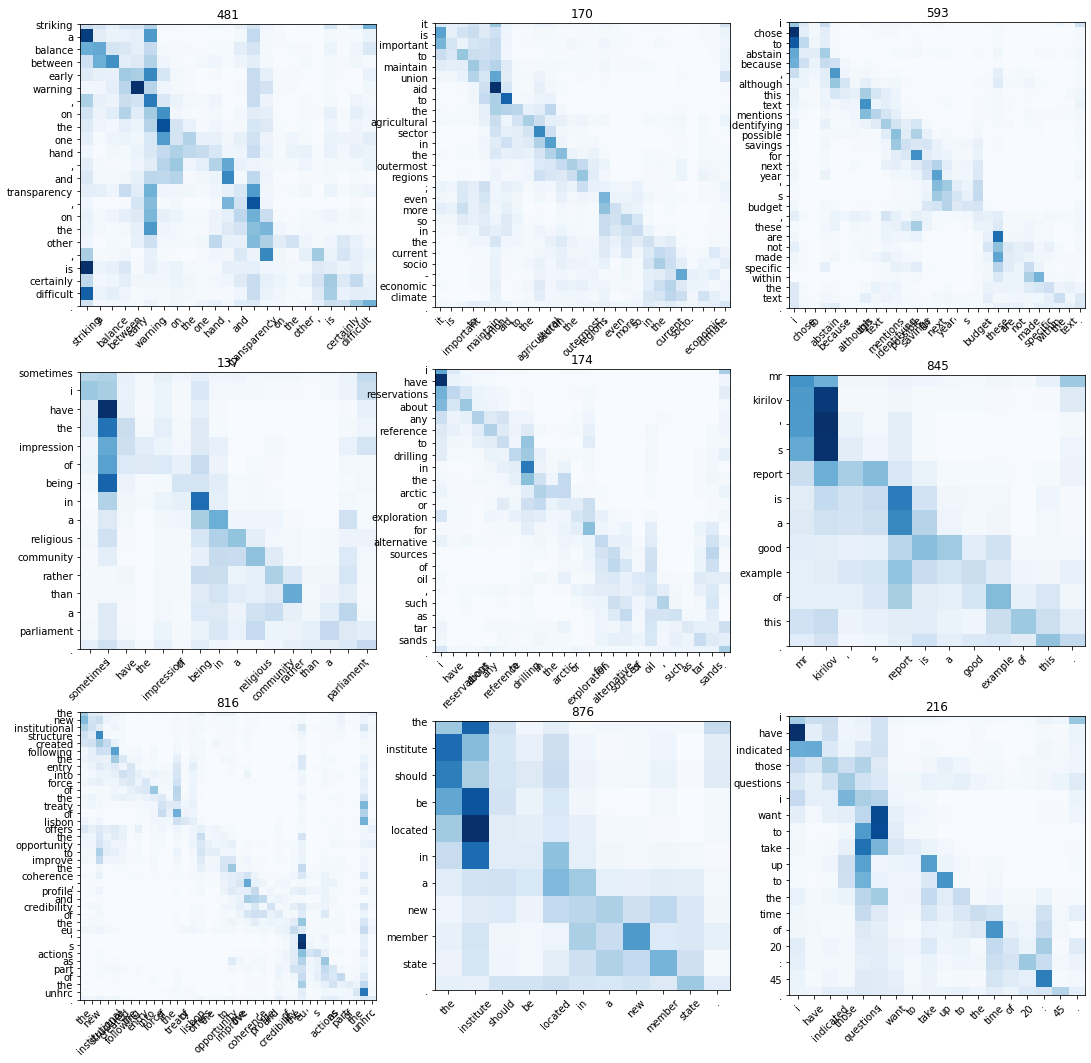

In [15]:
plot_head(viss,words_lists, [4,7,8], [10, 11, 10])

## Best subject d2p (dev: 70.4%)

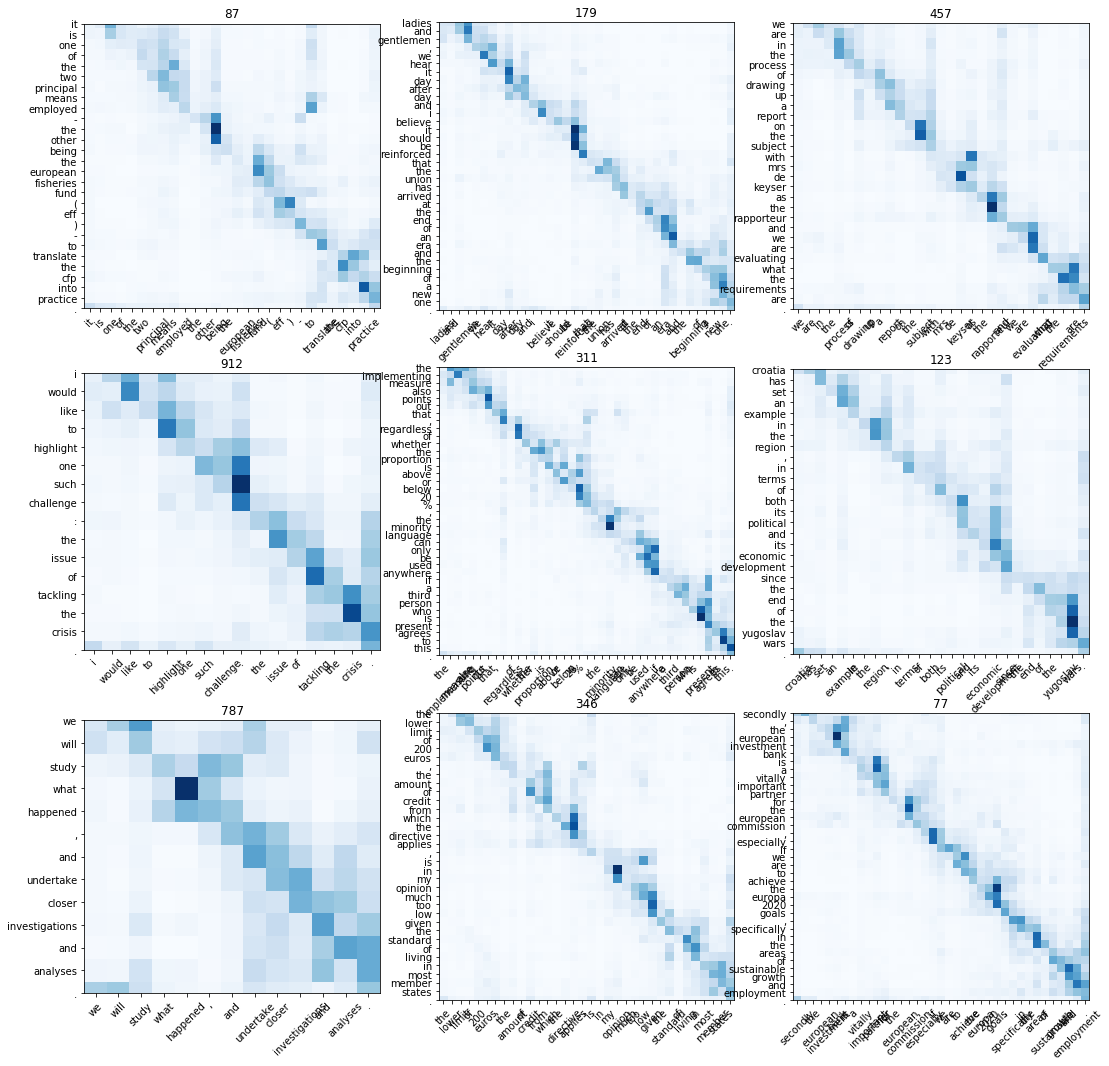

In [27]:
plot_head(viss,words_lists, [5, 4, 7, 6, 7, 8, 3, 5, 0],[ 0,  5,  1,  5,  2,  9,  3, 11,  8])

## Best object d2p (dev: 82.7%)

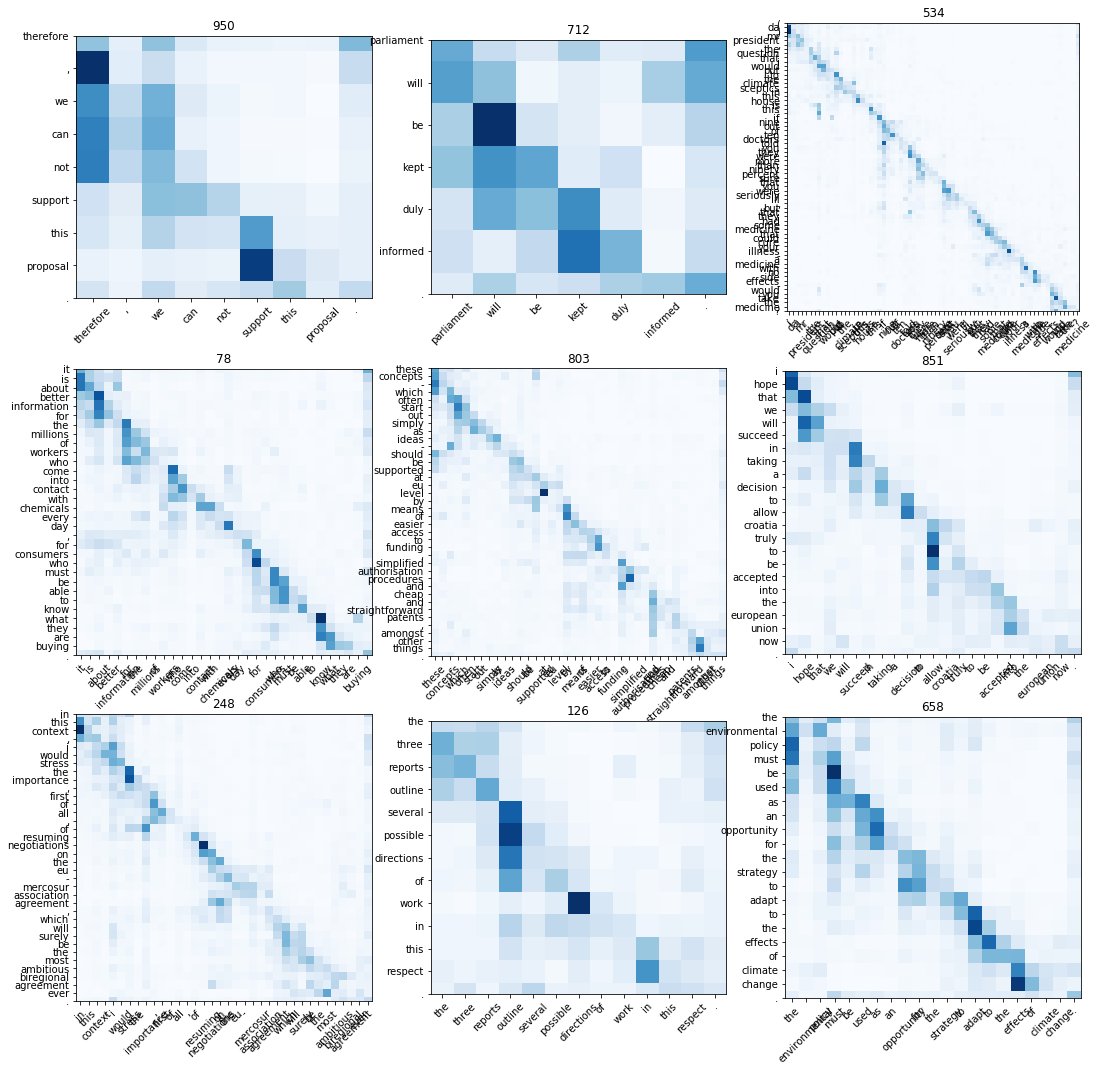

In [16]:
plot_head(viss,words_lists,[7, 6, 3, 6, 4, 5, 3],[ 9,  9, 11, 10,  6,  3,  8])

## auxiliary d2p (dev: 87.9 %)

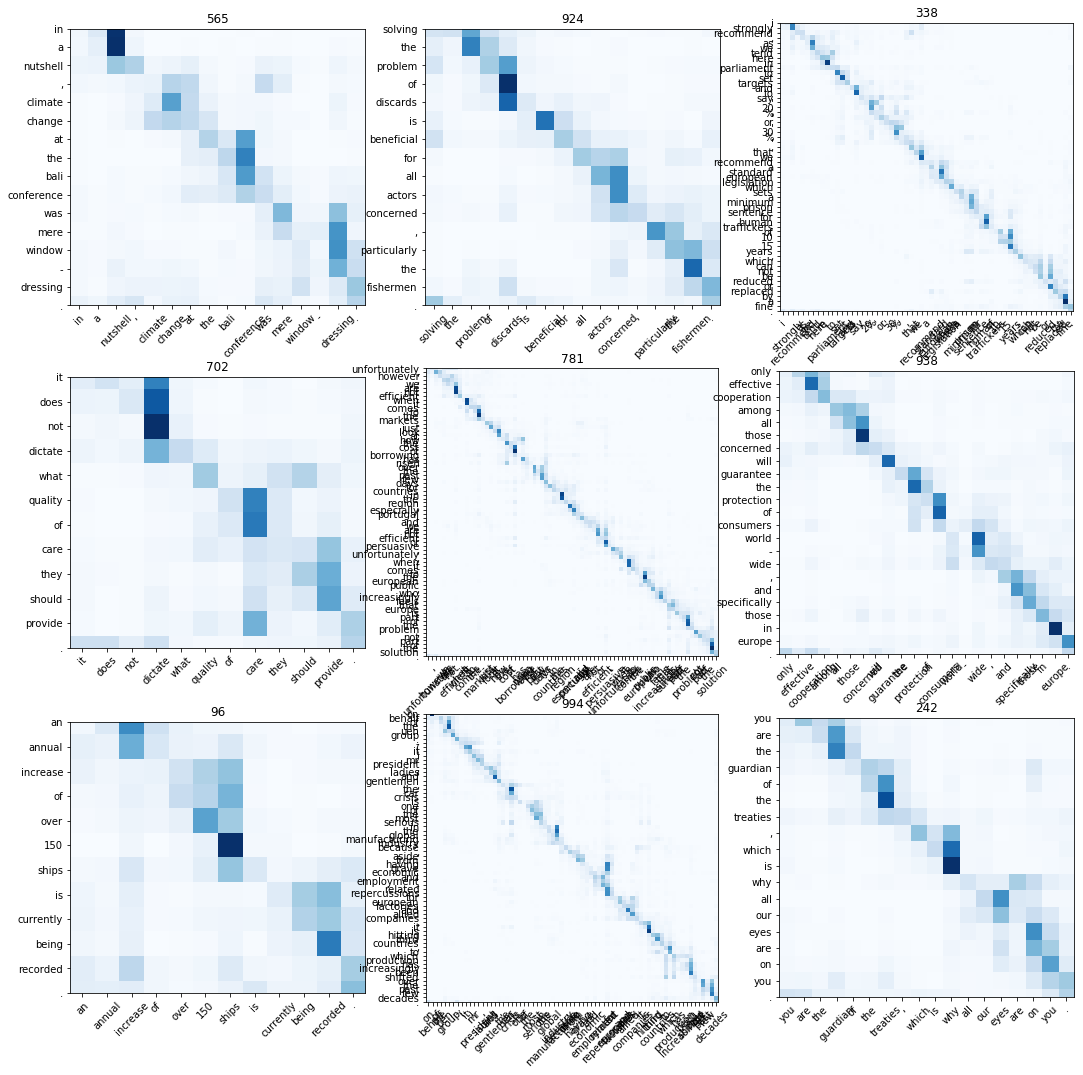

In [21]:
plot_head(viss,words_lists,[3, 7, 5, 8, 6, 5, 4, 7],[ 9,  6,  7,  5,  5,  0,  5, 10])

## Adjective modifier d2p : (dev: 83.9 %)


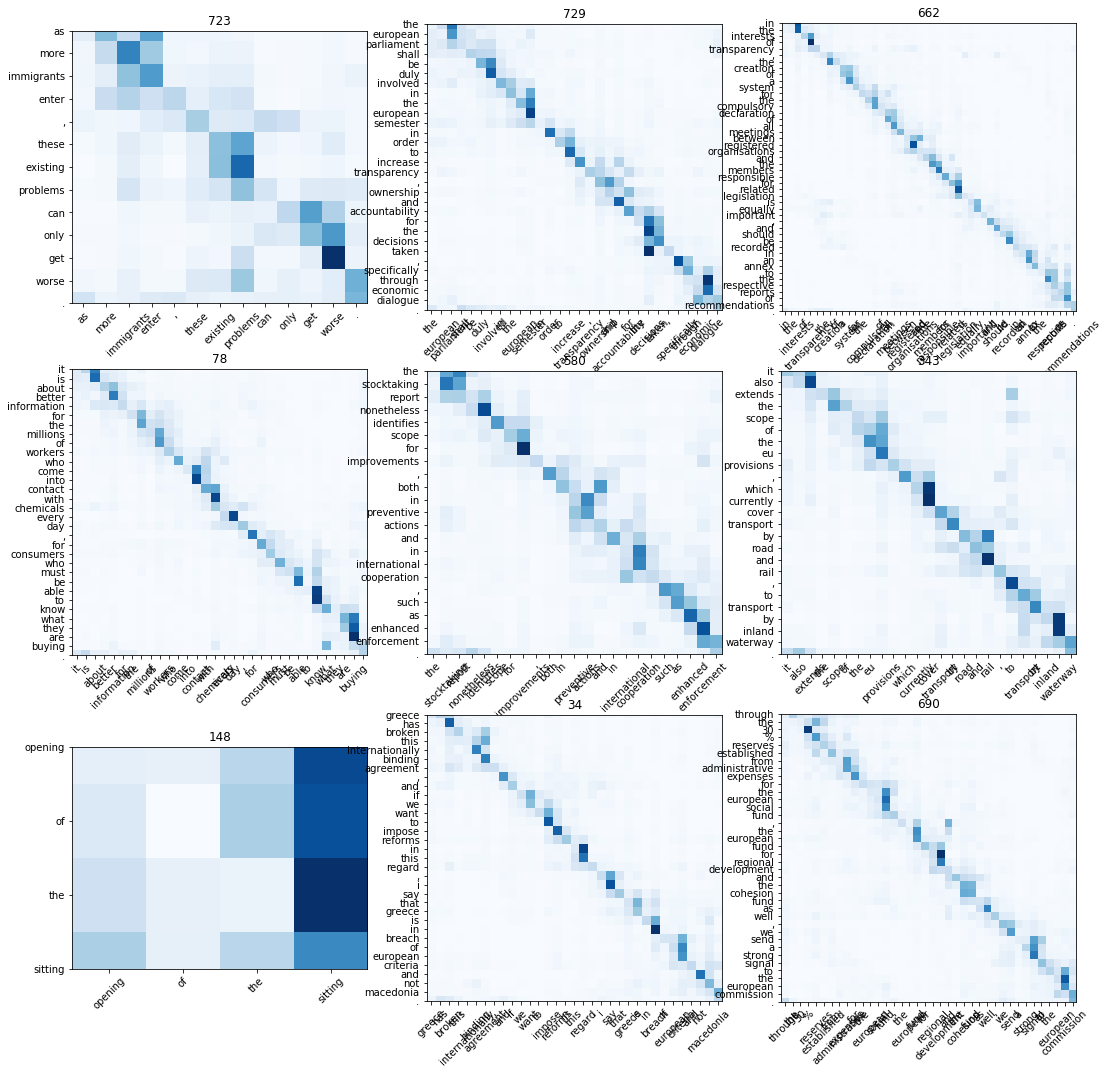

In [22]:
plot_head(viss,words_lists,[3, 7, 5, 8, 7, 0],[ 9, 10,  7,  5,  6,  8])

## Determiner d2p (dev: 89.4%)


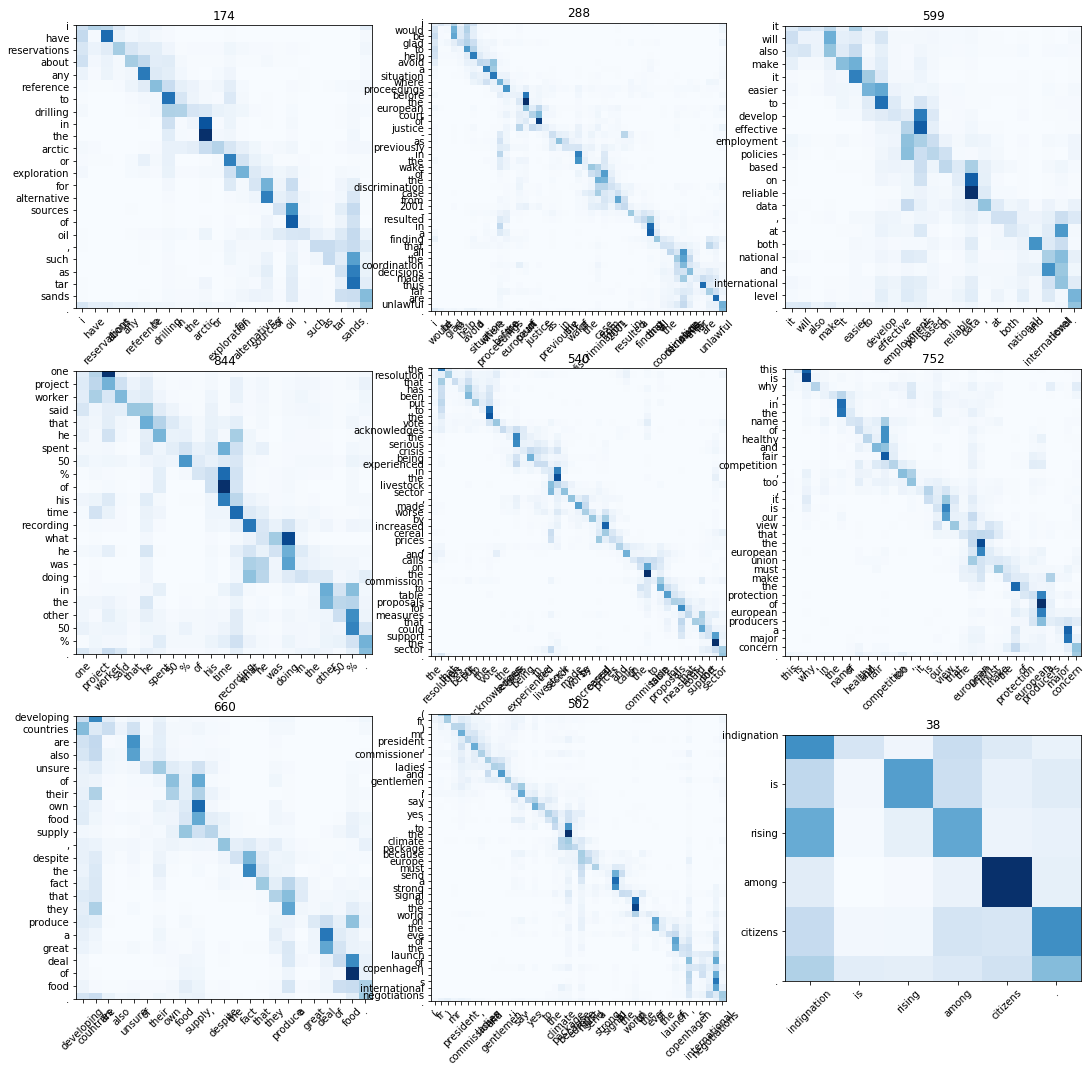

In [25]:
plot_head(viss,words_lists,[7, 3, 4, 8], [10,  9,  5, 10])

## Evaluate syntactic alignment

In [6]:
import dependency
from tqdm import tqdm

In [7]:
conllu_file_name = '../data/entest.conllu'

dependency_rels = dependency.read_conllu(conllu_file_name, directional=True)

In [9]:
def average_heads(all_matrices, ls, hs):
    return np.average(all_matrices[ls,hs,:,:], axis=0)

def uas_from_matrices(matrices, dep_rels):
    retrived = defaultdict(int)
    total = defaultdict(int)
    for matrix, dep_rel in zip(matrices, dep_rels):
        retr_pairs = set(zip(range(matrix.shape[0]), np.argmax(matrix, axis=1)))
        for rel_type, rel_pairs in dep_rel.items():
            retrived[rel_type] += len(set(rel_pairs).intersection(retr_pairs) )
            total[rel_type] += len(set(rel_pairs))
    
    for k in sorted(retrived.keys()):
        if total[k] > 0:
            print(f"UAS for {k} : {retrived[k]/total[k]} (number of relations: {total[k]})")
        else:
            print(f"No relations for {k}")